Here, we want to test the statistical procedures that are going to be applied in the testing of the different TA.

In [1]:
from trading import Asset
from datetime import date
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [9]:
data1 = np.random.normal( loc = -10 , scale = 10, size = 1000) / 100
data2 = np.random.normal( loc = 10 , scale = 10, size = 1000) / 100
data3 = np.random.normal( loc = 10 , scale = 10, size = 1000) / 100

(array([[ 1.,  1.,  1.,  2.,  5.,  2.,  3.,  1.,  4.,  2.,  4.,  3.,  6.,
          8.,  4.,  6.,  9.,  8., 23., 21., 12., 17., 15., 22., 21., 19.,
         32., 25., 25., 25., 36., 22., 26., 40., 25., 46., 29., 27., 31.,
         28., 22., 32., 25., 32., 18., 27., 22., 27., 23., 19., 15., 16.,
         16., 10.,  9., 12.,  7.,  7.,  5.,  4.,  5.,  1.,  0.,  0.,  1.,
          4.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  2.,  0.,  0.,
          1.,  1.,  0.,  1.,  2.,  2., 10.,  2.,  9.,  7., 10., 12., 10.,
         14., 10., 11., 10., 19., 16., 15., 17., 25., 21., 13., 24., 20.,
         33., 35., 26., 27., 33., 23., 28., 36., 30., 34., 34., 24., 31.,
         30., 25., 24., 18., 28., 24., 16., 18., 12., 15.

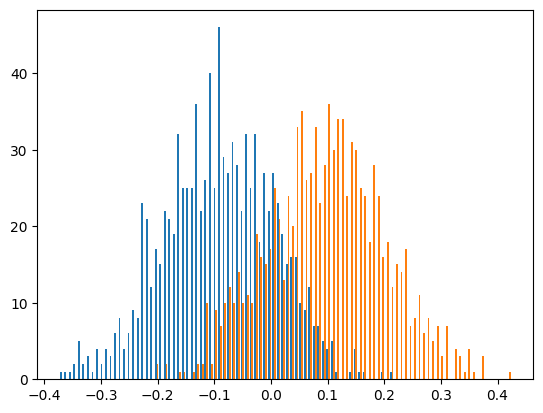

In [10]:
plt.hist( [ data1, data2 ] , bins = 100)

# Kolmogorov-Smirnov test for distribution similarity

The null hypothesis is that the two distributions are identical.

The alternative is that they are not identical.

In [11]:
from scipy import stats


In [12]:
stats.kstest(data1, data2)

KstestResult(statistic=0.648, pvalue=3.0955112783356777e-198)

Pvalue is lower than the 5% level, thus the two distributions are different.

In [13]:
stats.kstest(data3, data2)

KstestResult(statistic=0.031, pvalue=0.7228251828701066)

Pvalue is higher than the 5%, thus they are very similar.

With these tests, we just corroborate that the kolmogorov-smirnov test can work for our distribution tests.

## Buy/Sell distribution similarity test

Obtaining the distribution of the application of a TA, can let us apply the kolmogorov-smirnov test, and if they are very different, thus, the signals on the TA differ according to the future market movement (up/down); if the test accepts the null hypothesis, then, the TA cannot predict the market movement, or cannot (or not trusty to) be used as an asset filter.

In [14]:
from ta_functions import *

In [36]:
asset = new()

# We are testing trend followers
nasset = trend(asset)

In [37]:
def tester(nasset, ta):

    dff = pd.DataFrame()

    for t in range( 1, 12 ):
        # t = 1
        nasset.df["target"] = nasset.df["close"].pct_change( t ).shift( t ).apply( lambda x: 1 if x > 0 else 0 )

        df = []

        for l in range( *TREND_FIRST_PARAM ):
            dist = []
            for i in [0, 1]:
                s = nasset.df[ nasset.df["target"] == i ][ f"{ta}_{l}" ].dropna()

                if len(s) == 0:
                    continue

                kde = stats.gaussian_kde(  s)
                x = np.linspace(  -0.1 , 0.1  ,100)
                dist.append( kde(x).tolist() )

            kst = stats.kstest( *tuple( dist ) )
            
            df.append([ l, kst.pvalue ])

        df = pd.DataFrame( df , columns = ["param", f"{t}_pvalue"])
        df.set_index( "param", inplace= True )

        dff = pd.concat([ dff, df ], axis = 1)

    return dff



#### SMA

In [38]:
dff = tester(nasset, "sma")

<AxesSubplot:xlabel='param'>

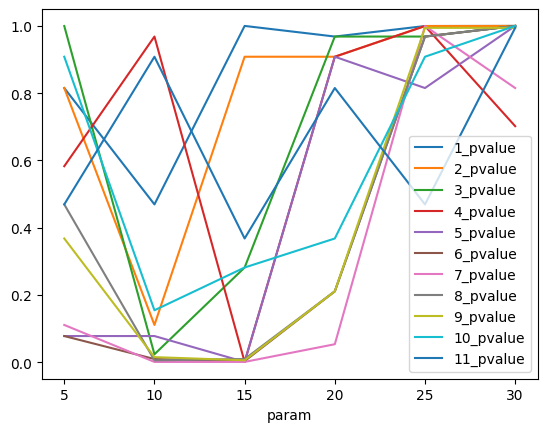

In [39]:
dff.iloc[:6].plot()

In [40]:
dff.iloc[:6]

,1_pvalue,2_pvalue,3_pvalue,4_pvalue,5_pvalue,6_pvalue,7_pvalue,8_pvalue,9_pvalue,10_pvalue,11_pvalue
param,,,,,,,,,,,
5,0.815415,0.815415,0.999689,0.583009,0.078221,0.078221,0.111195,0.469506,0.368188,0.908411,0.469506
10,0.469506,0.111195,0.024056,0.968410,0.078221,0.009878,0.001294,0.006134,0.015577,0.154839,0.908411
15,1.000000,0.908411,0.281942,0.001294,0.001294,0.003729,0.001294,0.009878,0.006134,0.281942,0.368188
20,0.968410,0.908411,0.968410,0.908411,0.908411,0.211170,0.053902,0.211170,0.211170,0.368188,0.815415
25,0.999689,0.999689,0.968410,0.999689,0.815415,0.968410,0.999689,0.968410,0.994236,0.908411,0.469506
30,1.000000,1.000000,1.000000,0.702057,0.999999,0.999689,0.815415,0.999999,0.994236,0.999999,0.994236


What this graph is telling us is that using the SMA at lengths of 10 - 15, the distribution of ups and downs 7 days forward are not similar (even lower than the 5% pvalue), this, it can be trusted up to a certain level to make it a filter.

#### EMA

In [41]:
dff = tester(nasset, "ema")

<AxesSubplot:xlabel='param'>

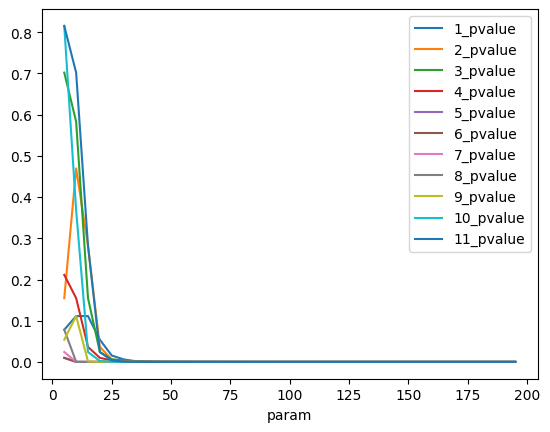

In [44]:
dff.plot()

The EMA plots result confusing, as they all have pvalues lower than the 5% (the greate majority).

Is there truly so much difference when using this TA?

#### WMA

In [45]:
dff = tester(nasset, "wma")

<AxesSubplot:xlabel='param'>

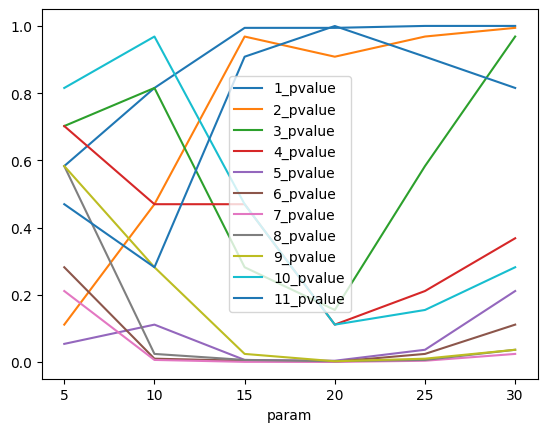

In [47]:
dff.iloc[ :6 ].plot()

Similar conclusions to the SMA can be drawned from the WMA. WMA with 10 - 25 days long can give a certain level of prediction to the movement of the market from 6 to 9 days in the future.

All this gathered from the difference in the distributions.